# 1‑D Vertical Rocket: Sensors + PID Closed‑Loop

This notebook builds on Steps 1–8 and adds Step 9 (sensor models + estimator) and Step 11 (PID altitude controller).

Run cells in order. The notebook is organized so you can run open-loop scenarios first, then closed-loop with noisy sensors and a simple estimator.


In [3]:
# Imports & plotting helpers
import numpy as np
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
%matplotlib inline

def clamp(x, lo, hi):
    return float(np.maximum(lo, np.minimum(hi, x)))

def plot_timeseries(t, series, labels=None, title=None, ylabel=None):
    plt.figure(figsize=(9,4))
    if np.ndim(series) == 1:
        plt.plot(t, series, lw=1.5)
        if labels: plt.legend(labels)
    else:
        for i, s in enumerate(series):
            lbl = labels[i] if labels and i < len(labels) else None
            plt.plot(t, s, lw=1.2, label=lbl)
        if labels: plt.legend()
    if title: plt.title(title)
    if ylabel: plt.ylabel(ylabel)
    plt.xlabel('time (s)')
    plt.grid(True)
    plt.tight_layout()


In [21]:
import random
example = random.randint(1,100)
print(np.ndim(example))

0


In [1]:
# Imports & plotting helpers
import numpy as np
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
%matplotlib inline

def clamp(x, lo, hi):
    return float(np.maximum(lo, np.minimum(hi, x)))

def plot_timeseries(t, series, labels=None, title=None, ylabel=None):
    plt.figure(figsize=(9,4))
    if np.ndim(series) == 1:
        plt.plot(t, series, lw=1.5)
        if labels: plt.legend(labels)
    else:
        for i, s in enumerate(series):
            lbl = labels[i] if labels and i < len(labels) else None
            plt.plot(t, s, lw=1.2, label=lbl)
        if labels: plt.legend()
    if title: plt.title(title)
    if ylabel: plt.ylabel(ylabel)
    plt.xlabel('time (s)')
    plt.grid(True)
    plt.tight_layout()


In [5]:
# Parameters and environment models (same as open-loop notebook)
@dataclass
class Params:
    g0: float = 9.80665
    R_earth: float = 6.371e6
    m_wet: float = 12.0
    m_dry: float = 8.0
    T_max: float = 250.0
    Isp: float = 220.0
    Cd: float = 0.6
    A: float = 0.02
    rho0: float = 1.225
    H: float = 8500.0
    tau_T: float = 0.12
    dt_default: float = 0.02

P = Params()

def rho_exp(h, P=P):
    return P.rho0 * np.exp(-np.clip(h, 0.0, None)/P.H)

def gravity(h, P=P):
    return P.g0 * (P.R_earth/(P.R_earth + h))**2

def drag_force(v, h, P=P):
    return 0.5 * rho_exp(h, P) * P.Cd * P.A * v * abs(v)

def mdot_from_thrust(T, P=P):
    return max(0.0, T) / (P.Isp * P.g0)


In [7]:
# State and RK4 dynamics
@dataclass
class State:
    h: float = 0.0
    v: float = 0.0
    m: float = P.m_wet
    T: float = 0.0  # actual thrust [N]

def dynamics_vec(s_vec, u_T_cmd, P=P):
    h, v, m, T = s_vec
    g = gravity(h, P)
    D = drag_force(v, h, P)
    a = (T - D)/max(m,1e-6) - g
    dh = v
    dv = a
    dm = -mdot_from_thrust(T, P)
    dT = (u_T_cmd - T) / P.tau_T
    return np.array([dh, dv, dm, dT], dtype=float)

def rk4_step(state, u_T_cmd, dt, P=P):
    s = np.array([state.h, state.v, state.m, state.T], dtype=float)
    k1 = dynamics_vec(s, u_T_cmd, P)
    k2 = dynamics_vec(s + 0.5*dt*k1, u_T_cmd, P)
    k3 = dynamics_vec(s + 0.5*dt*k2, u_T_cmd, P)
    k4 = dynamics_vec(s + dt*k3, u_T_cmd, P)
    s_next = s + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    next_state = State(*s_next)
    if next_state.h <= 0 and next_state.v < 0:
        next_state.h = 0.0
        next_state.v = 0.0
    next_state.m = max(next_state.m, P.m_dry)
    next_state.T = max(0.0, min(next_state.T, P.T_max))
    return next_state


In [9]:
# Sensor models: altimeter and accelerometer (noisy)
# Altimeter: measures altitude at a lower rate (e.g., 20 Hz)
# Accelerometer: measures acceleration (a = dv/dt) at higher rate with bias + noise

@dataclass
class SensorParams:
    altimeter_rate: float = 20.0   # Hz
    altimeter_sigma: float = 0.2   # m (std dev)
    accel_rate: float = 100.0      # Hz
    accel_sigma: float = 0.5       # m/s^2 (std dev)
    accel_bias: float = 0.0        # m/s^2

S = SensorParams()

def altimeter_measure(h_true):
    return h_true + np.random.normal(0.0, S.altimeter_sigma)

def accelerometer_measure(a_true):
    return a_true + S.accel_bias + np.random.normal(0.0, S.accel_sigma)


In [11]:
# Complementary filter estimator for h and v
# Integrate accelerometer to get velocity, combine with finite-difference altimeter

class ComplementaryEstimator:
    def __init__(self, dt, alpha=0.98):
        self.dt = dt
        self.alpha = alpha
        self.h_est = 0.0
        self.v_est = 0.0
        self.last_alt_meas = None
        self.t_last_alt = -1e9
    def reset(self, h0=0.0, v0=0.0):
        self.h_est = h0; self.v_est = v0; self.last_alt_meas = None; self.t_last_alt = -1e9
    def predict(self, a_meas):
        # propagate velocity and altitude by integrating accelerometer
        self.v_est += a_meas * self.dt
        self.h_est += self.v_est * self.dt
    def update_with_altimeter(self, t, alt_meas):
        # if altimeter measurement available, do a complementary blend
        if self.last_alt_meas is None:
            # initialize
            self.last_alt_meas = alt_meas
            self.t_last_alt = t
            return
        dt_alt = t - self.t_last_alt
        if dt_alt <= 0:
            return
        # velocity from altimeter by finite difference
        v_from_alt = (alt_meas - self.last_alt_meas) / dt_alt
        # blend velocities and heights
        self.v_est = self.alpha * self.v_est + (1.0 - self.alpha) * v_from_alt
        self.h_est = self.alpha * self.h_est + (1.0 - self.alpha) * alt_meas
        self.last_alt_meas = alt_meas
        self.t_last_alt = t


In [13]:
# PID altitude controller
class PIDController:
    def __init__(self, kp, ki, kd, umin=0.0, umax=1.0):
        self.kp = kp; self.ki = ki; self.kd = kd
        self.umin = umin; self.umax = umax
        self.I = 0.0; self.e_prev = 0.0
        self.last_u = 0.0
    def reset(self):
        self.I = 0.0; self.e_prev = 0.0; self.last_u = 0.0
    def update(self, e, de, dt):
        # PID with simple integrator anti-windup via clamping
        self.I += e * dt
        u = self.kp*e + self.ki*self.I + self.kd*de
        u_clamped = clamp(u, self.umin, self.umax)
        # anti-windup: back-calculate integral correction
        if self.ki != 0:
            self.I += (u_clamped - u) / self.ki
        self.last_u = u_clamped
        return u_clamped

# Map desired acceleration to thrust (feedforward + compensation)
def accel_to_thrust_fraction(a_des, h_est, v_est, m_est, P=P):
    # compute nominal thrust required: T = m*(a + g) + D_est
    g = gravity(h_est, P)
    D_est = 0.5 * rho_exp(h_est, P) * P.Cd * P.A * v_est * abs(v_est)
    T_req = m_est * (a_des + g) + D_est
    frac = T_req / P.T_max
    return clamp(frac, 0.0, 1.0)


In [15]:
# Closed-loop simulation that uses noisy sensors and complementary estimator

def simulate_closed_loop(h_ref, t_final=30.0, dt=0.02, use_estimator=True, P=P, S=S):
    # controllers & estimator
    pid = PIDController(kp=0.5, ki=0.05, kd=0.1, umin=0.0, umax=1.0)
    est = ComplementaryEstimator(dt=dt, alpha=0.98)
    pid.reset(); est.reset()

    # initial state
    state = State(h=0.0, v=0.0, m=P.m_wet, T=0.0)
    t = 0.0
    next_altimeter_time = 0.0

    ts, hs, vs, ms, us_cmd, Ts_act, h_est_arr, v_est_arr = [], [], [], [], [], [], [], []

    while t < t_final - 1e-12:
        # true acceleration for sensor
        a_true = (state.T - drag_force(state.v, state.h, P))/max(state.m,1e-6) - gravity(state.h, P)
        # accelerometer measurement (available every step)
        a_meas = accelerometer_measure(a_true)

        # predictor step for estimator
        est.predict(a_meas)

        # altimeter measurement at its rate
        if t >= next_altimeter_time - 1e-12:
            h_meas = altimeter_measure(state.h)
            est.update_with_altimeter(t, h_meas)
            next_altimeter_time += 1.0 / S.altimeter_rate

        # control: error based on estimator or true state
        if use_estimator:
            h_err = h_ref - est.h_est
            dh = 0.0 - est.v_est
        else:
            h_err = h_ref - state.h
            dh = 0.0 - state.v

        # PID computes desired acceleration (a_d). Here we map PID output range to reasonable accel
        # For convenience, treat PID output directly as desired acceleration [m/s^2]
        a_d = pid.update(h_err, dh, dt)

        # map to thrust fraction
        if use_estimator:
            frac = accel_to_thrust_fraction(a_d, est.h_est, est.v_est, state.m, P)
        else:
            frac = accel_to_thrust_fraction(a_d, state.h, state.v, state.m, P)

        u_T_cmd = frac * P.T_max

        # log
        ts.append(t); hs.append(state.h); vs.append(state.v); ms.append(state.m)
        us_cmd.append(frac); Ts_act.append(state.T)
        h_est_arr.append(est.h_est); v_est_arr.append(est.v_est)

        # step dynamics
        state = rk4_step(state, u_T_cmd, dt, P)
        t += dt

    return (np.array(ts), np.array(hs), np.array(vs), np.array(ms), np.array(us_cmd), np.array(Ts_act), np.array(h_est_arr), np.array(v_est_arr))


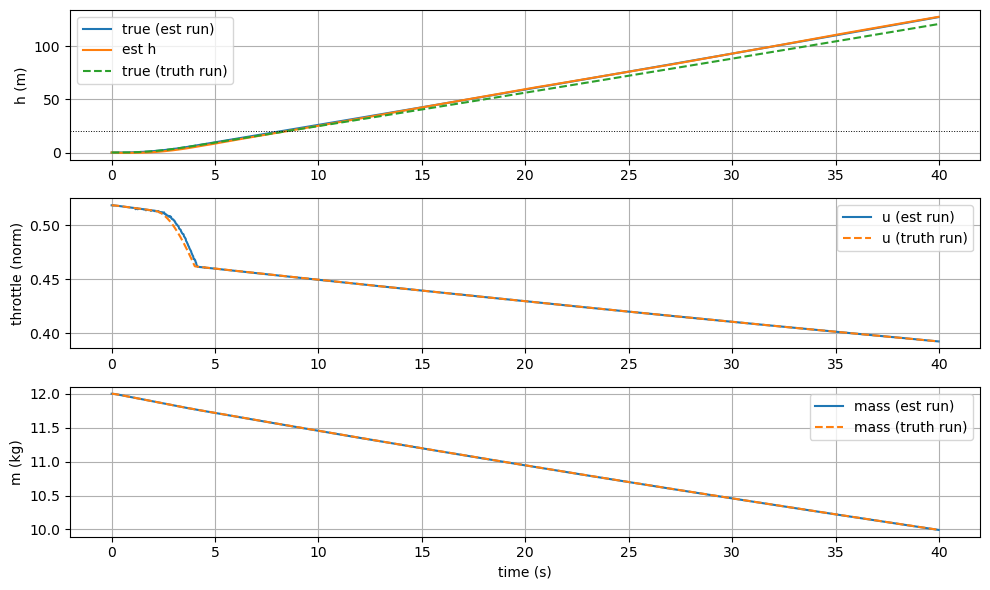

In [17]:
# Demo runs: use estimator vs truth
res_est = simulate_closed_loop(h_ref=20.0, t_final=40.0, dt=0.02, use_estimator=True)
res_true = simulate_closed_loop(h_ref=20.0, t_final=40.0, dt=0.02, use_estimator=False)

(ts_e, h_e, v_e, m_e, u_e, T_e, hest_e, vest_e) = res_est
(ts_t, h_t, v_t, m_t, u_t, T_t, hest_t, vest_t) = res_true

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(ts_e, h_e, label='true (est run)')
plt.plot(ts_e, hest_e, label='est h')
plt.plot(ts_t, h_t, ls='--', label='true (truth run)')
plt.axhline(20.0, color='k', lw=0.7, ls=':')
plt.ylabel('h (m)'); plt.legend(); plt.grid(True)

plt.subplot(3,1,2)
plt.plot(ts_e, u_e, label='u (est run)')
plt.plot(ts_t, u_t, ls='--', label='u (truth run)')
plt.ylabel('throttle (norm)'); plt.legend(); plt.grid(True)

plt.subplot(3,1,3)
plt.plot(ts_e, m_e, label='mass (est run)')
plt.plot(ts_t, m_t, ls='--', label='mass (truth run)')
plt.ylabel('m (kg)'); plt.xlabel('time (s)'); plt.legend(); plt.grid(True)
plt.tight_layout()


## Notes and next steps

- The estimator implemented is a **complementary filter** (simple, robust). For better performance you can implement a Kalman filter (Step 13).
- The PID controller here outputs a desired vertical acceleration and we convert that to thrust via a feedforward formula (mass, gravity, drag). This inner mapping is crucial for good performance.
- Next: Monte Carlo robustness (Step 12) or implement a Kalman filter and compare estimators.
